In [2]:
from imports import *

# Image creation

In [2]:
# Load the matrices from CSV files into separate variables
file_names = ["pe_matrix", "time_matrix", "vis_map_realistic", "vuv_map_realistic", "coated_pmt_map_realistic", "uncoated_pmt_map_realistic" ,"xarap_vis_map_realistic" , "xarap_vuv_map_realistic", "vis_map_compressed", "vuv_map_compressed", "coated_pmt_map_compressed", "uncoated_pmt_map_compressed", "xarap_vis_map_compressed", "xarap_vuv_map_compressed"]

for i, name in enumerate(file_names):
    if i < 2:  # The first two files as float
        locals()[name] = np.loadtxt(f"saved_archives/pe_matrix_&_time_matrix/{name}.csv", delimiter=",")
    elif 2 <= i < 8:  # The next two files as int
        locals()[name] = np.loadtxt(f"saved_archives/maps/realistic/{name}.csv", delimiter=",", dtype=int)
    else:  # The remaining files as int
        locals()[name] = np.loadtxt(f"saved_archives/maps/compressed/{name}.csv", delimiter=",", dtype=int)

## VIS/VUV map creation

In [5]:
# Create the images using realistic and compressed maps
image_realistic_visvuv = image_creator_gen(pe_matrix,time_matrix,vis_map_realistic,vuv_map_realistic)
image_compressed_visvuv = image_creator_gen(pe_matrix,time_matrix,vis_map_compressed,vuv_map_compressed)

print('Number of events, image height, width, layers:', np.shape(image_realistic_visvuv ))
print('Number of events, image height, width, layers:', np.shape(image_compressed_visvuv ))

Number of events, image height, width, layers: (28921, 59, 70, 8)
Number of events, image height, width, layers: (28921, 9, 36, 8)


**save data**

In [6]:
# Save the matrices to a npy file
np.save("/data/vidales/images/image_realistic_visvuv.npy", image_realistic_visvuv)
np.save("/data/vidales/images/image_compressed_visvuv.npy", image_compressed_visvuv)
#np.save("saved_archives/images/image_realistic_visvuv.npy", image_realistic_visvuv)
#np.save("saved_archives/images/image_compressed_visvuv.npy", image_compressed_visvuv)

# 4-component map creation

In [3]:
image_realistic_4comp = image_creator_gen(pe_matrix, time_matrix, coated_pmt_map_realistic, uncoated_pmt_map_realistic, xarap_vis_map_realistic, xarap_vuv_map_realistic)
image_compressed_4comp = image_creator_gen(pe_matrix, time_matrix, coated_pmt_map_compressed, uncoated_pmt_map_compressed, xarap_vis_map_compressed, xarap_vuv_map_compressed)

print('Number of events, image height, width, layers:', np.shape(image_realistic_4comp))
print('Number of events, image height, width, layers:', np.shape(image_compressed_4comp))

Number of events, image height, width, layers: (29582, 59, 70, 16)
Number of events, image height, width, layers: (29582, 9, 36, 16)


**save data**

In [4]:
# Save the matrices to a npy file
np.save("/data/vidales/images/image_realistic_4comp.npy", image_realistic_4comp)
np.save("/data/vidales/images/image_compressed_4comp.npy", image_compressed_4comp)
#np.save("saved_archives/images/image_realistic_4comp.npy", image_realistic_4comp)
#np.save("saved_archives/images/image_compressed_4comp.npy", image_compressed_4comp)

# Visualization of generated images

## 4-component visualization

**load data**

In [5]:
image_realistic_4comp = np.load("/data/vidales/images/image_realistic_4comp.npy")

KeyboardInterrupt: 

In [1]:
labels_4comp = [
        "PE1: Coated PMT/Volume -", "PE2: Coated PMT/Volume +", "T1: Coated PMT/Volume -", "T2: Coated PMT/Volume +", 
        "PE1: Uncoated PMT/Volume -", "PE2: Uncoated PMT/Volume +", "T1: Uncoated PMT/Volume -", "T2: Uncoated PMT/Volume +", 
        "PE1: XA VIS/Volume -", "PE2: XA VIS/Volume +", "T1: XA VIS/Volume -", "T2: XA VIS/Volume +", 
        "PE1: XA VUV/Volume -", "PE2: XA VUV/Volume +", "T1: XA VUV/Volume -", "T2: XA VUV/Volume +"
    ]
    
groups_4comp = [
        [0, 1, 4, 5],    # First group
        [2, 3, 6, 7],    # Second group
        [8, 9, 12, 13],  # Third group
        [10, 11, 14, 15] # Fourth group
    ]

grid_4comp =(4,4)
event_idx=23000

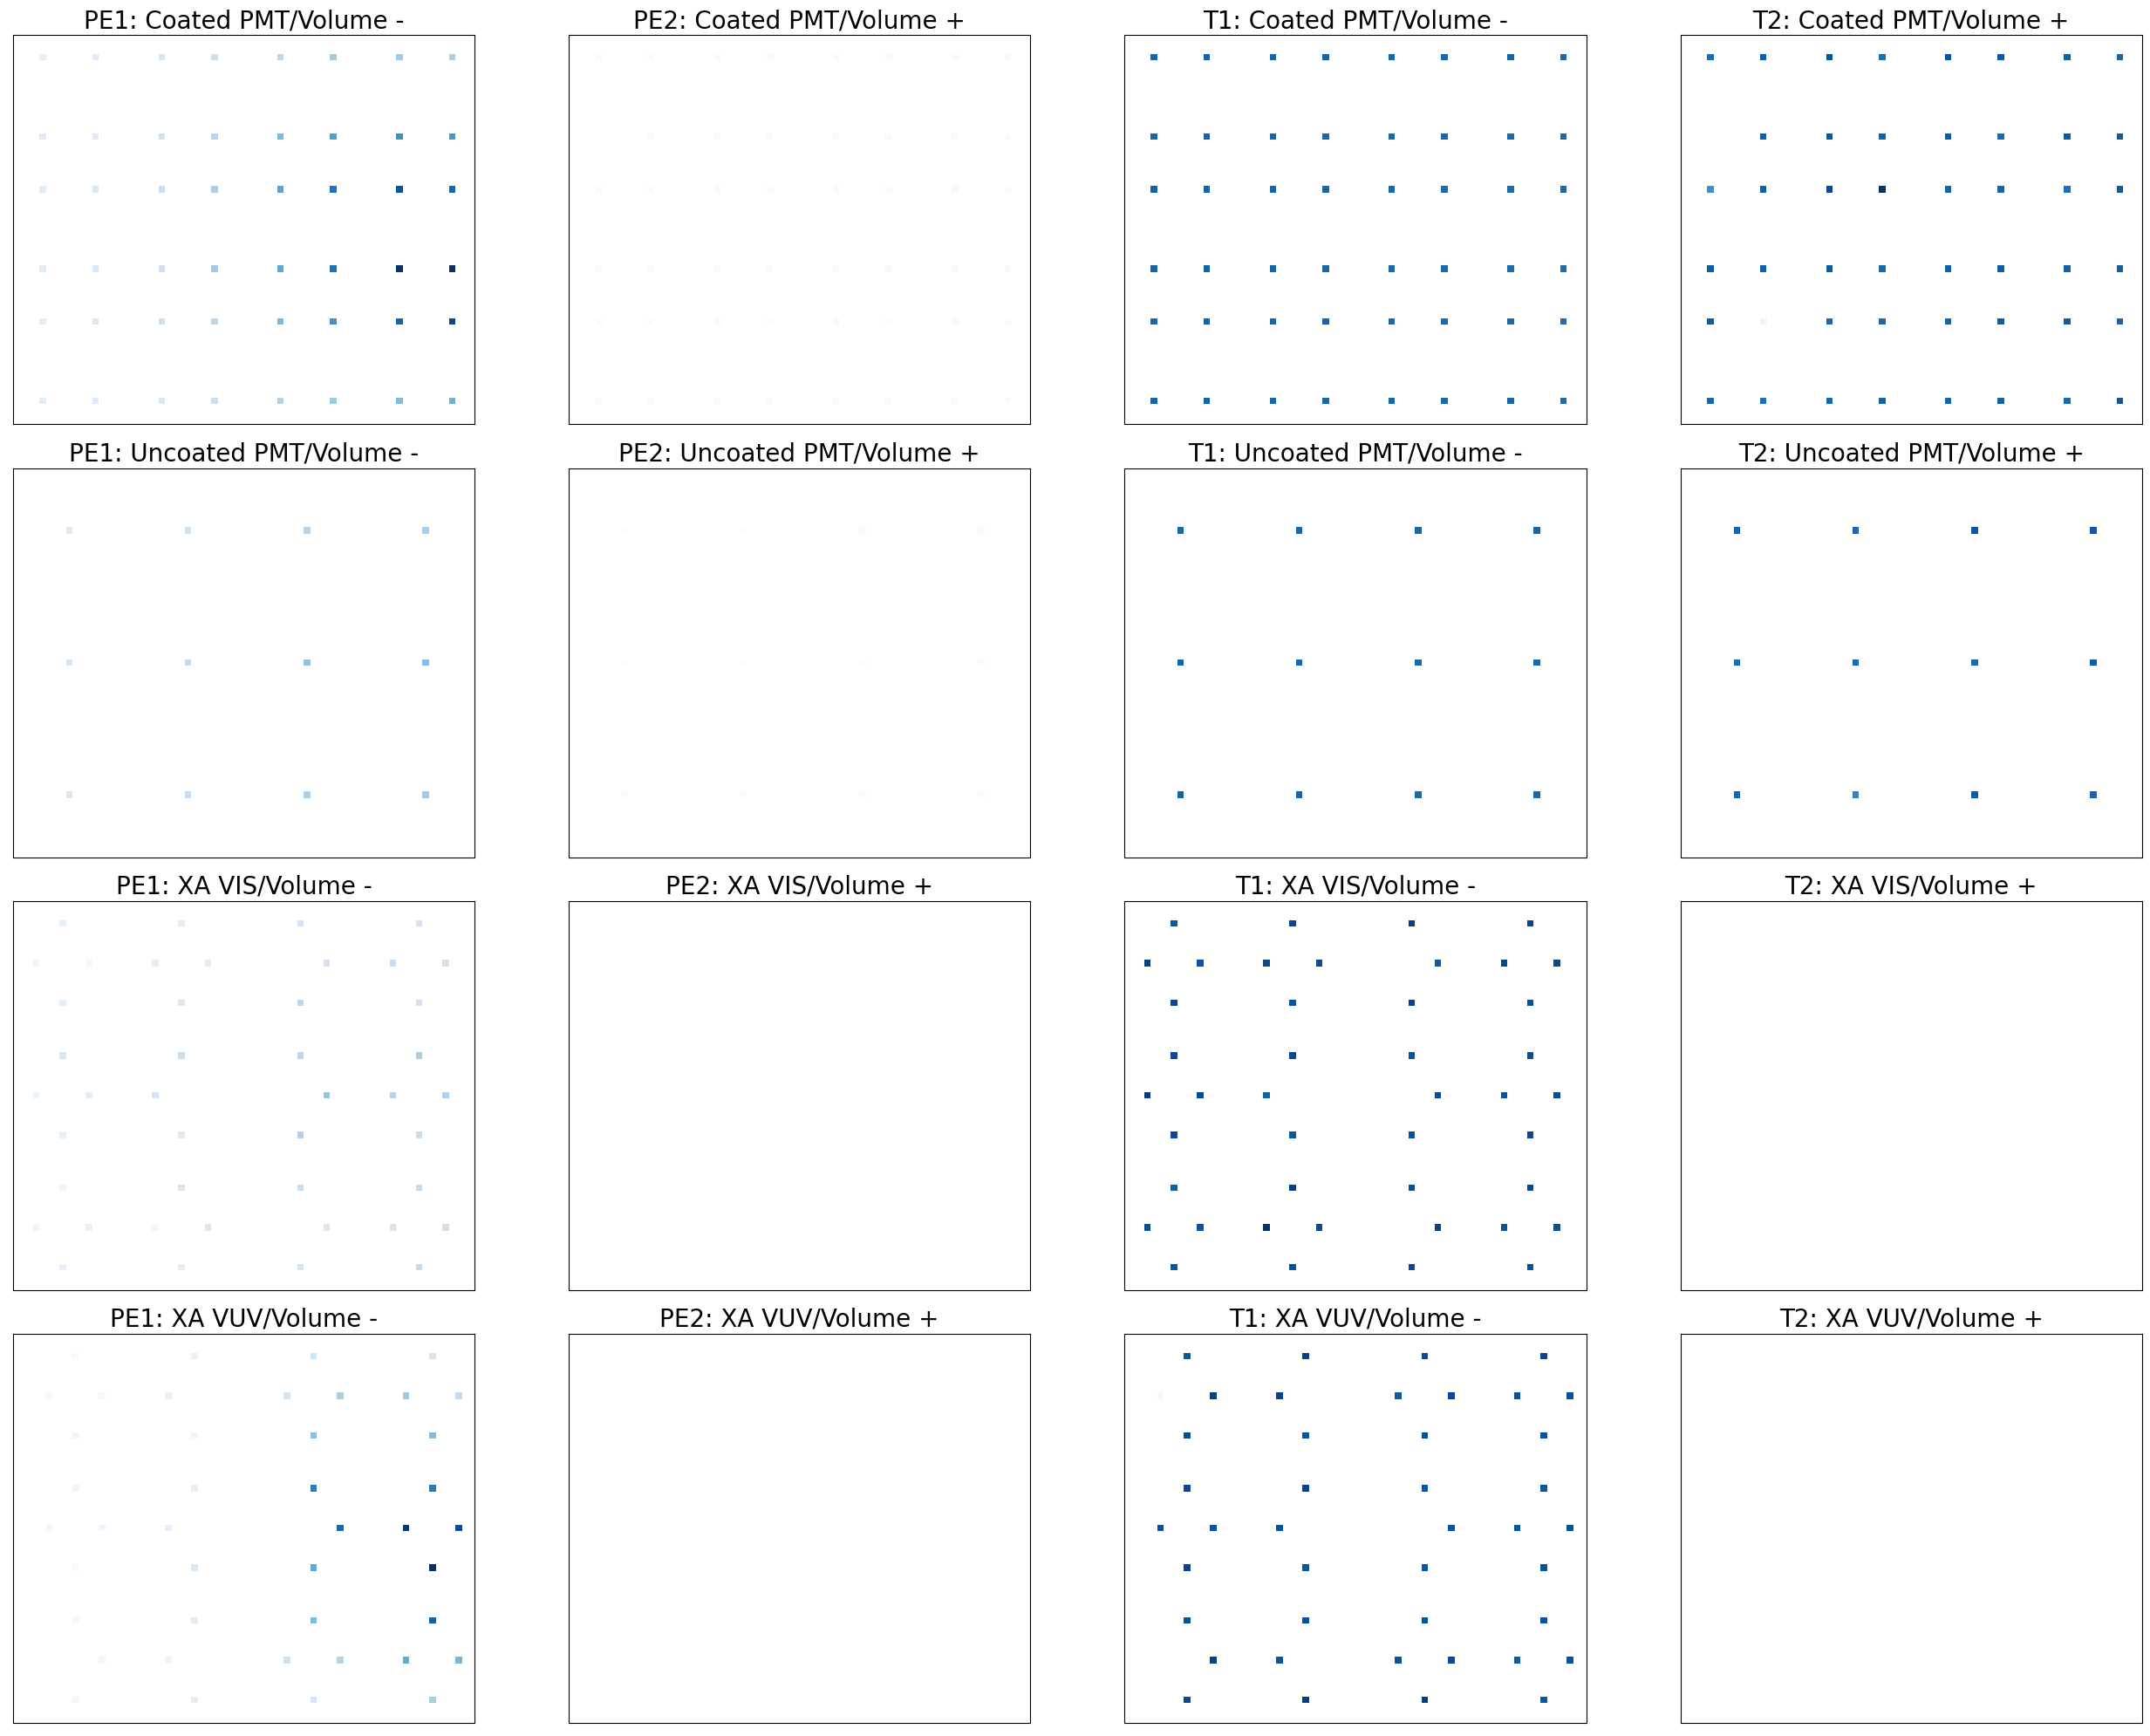

In [12]:
plot_image(image_realistic_4comp, event_idx, labels_4comp, groups_4comp, grid_4comp, figsize=(26, 20))

(<Figure size 2600x1000 with 16 Axes>,
 array([<AxesSubplot:title={'center':'PE1: Coated PMT/Volume -'}>,
        <AxesSubplot:title={'center':'PE2: Coated PMT/Volume +'}>,
        <AxesSubplot:title={'center':'T1: Coated PMT/Volume -'}>,
        <AxesSubplot:title={'center':'T2: Coated PMT/Volume +'}>,
        <AxesSubplot:title={'center':'PE1: Uncoated PMT/Volume -'}>,
        <AxesSubplot:title={'center':'PE2: Uncoated PMT/Volume +'}>,
        <AxesSubplot:title={'center':'T1: Uncoated PMT/Volume -'}>,
        <AxesSubplot:title={'center':'T2: Uncoated PMT/Volume +'}>,
        <AxesSubplot:title={'center':'PE1: XA VIS/Volume -'}>,
        <AxesSubplot:title={'center':'PE2: XA VIS/Volume +'}>,
        <AxesSubplot:title={'center':'T1: XA VIS/Volume -'}>,
        <AxesSubplot:title={'center':'T2: XA VIS/Volume +'}>,
        <AxesSubplot:title={'center':'PE1: XA VUV/Volume -'}>,
        <AxesSubplot:title={'center':'PE2: XA VUV/Volume +'}>,
        <AxesSubplot:title={'center':'T1: XA 

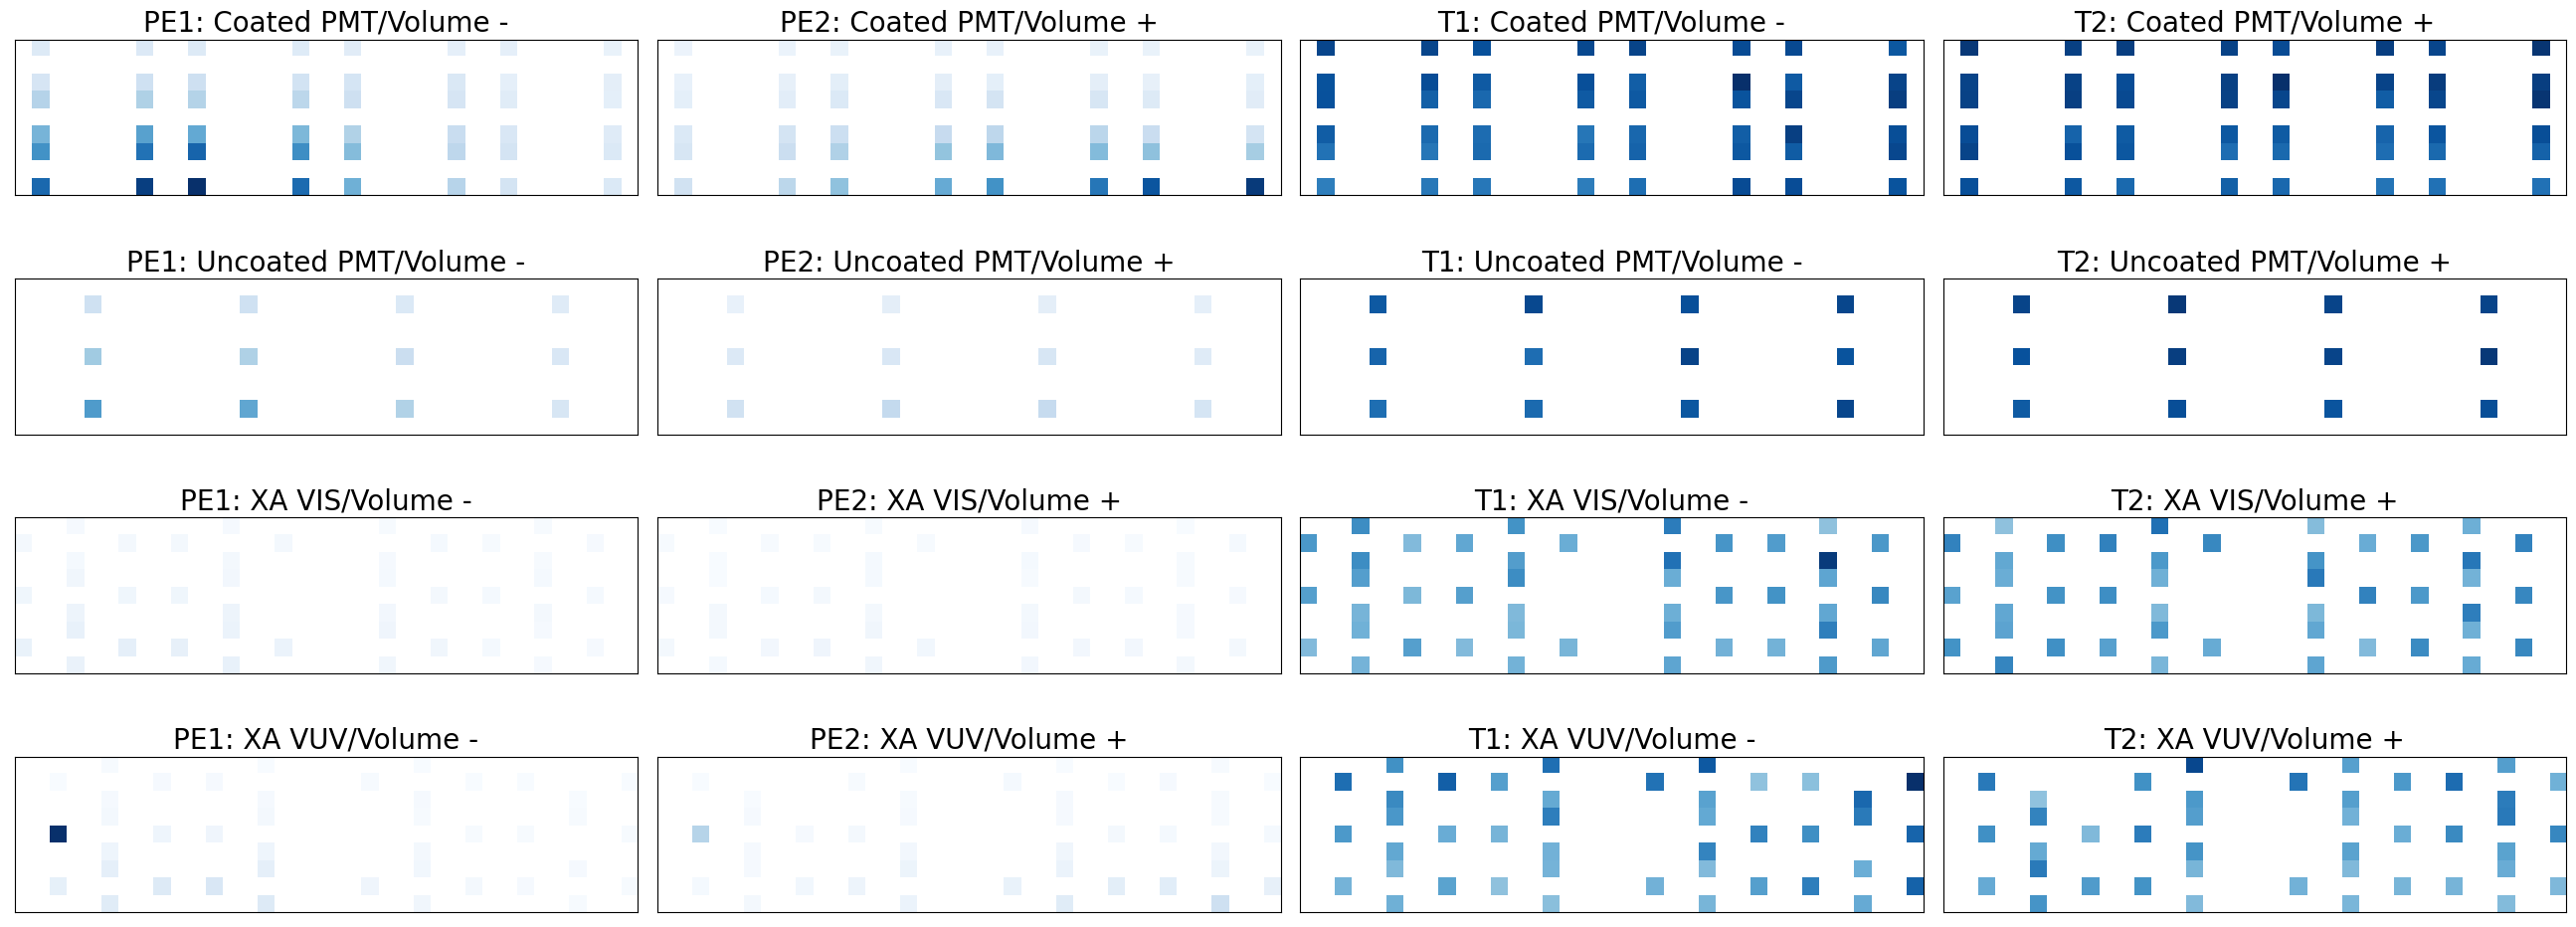

In [16]:
plot_image(image_compressed_4comp, event_idx, labels_4comp, groups_4comp, grid_4comp, figsize=(26, 10))

# VIS/VUV visualization

**load data**

In [10]:
#image_realistic_visvuv= np.load("saved_archives/images/image_realistic_visvuv.npy")
#image_compressed_visvuv = np.load("saved_archives/images/image_compressed_visvuv.npy")

In [8]:
labels_visvuv = [
    "PE1: Visible/Volume -", "PE2: Visible/Volume +", 
    "T1: Visible/Volume -", "T2: Visible/Volume +", 
    "PE3: Ultraviolet/Volume -", "PE4: Ultraviolet/Volume +", 
    "T3: Ultraviolet/Volume -", "T4: Ultraviolet/Volume +"
]
groups_visvuv = [
    [0, 1, 4, 5], # First group
    [2, 3, 6, 7]  # Second group
]
grid_visvuv = (2,4)
event_idx = 570

(<Figure size 2600x1000 with 8 Axes>,
 array([<AxesSubplot:title={'center':'PE1: Visible/Volume -'}>,
        <AxesSubplot:title={'center':'PE2: Visible/Volume +'}>,
        <AxesSubplot:title={'center':'T1: Visible/Volume -'}>,
        <AxesSubplot:title={'center':'T2: Visible/Volume +'}>,
        <AxesSubplot:title={'center':'PE3: Ultraviolet/Volume -'}>,
        <AxesSubplot:title={'center':'PE4: Ultraviolet/Volume +'}>,
        <AxesSubplot:title={'center':'T3: Ultraviolet/Volume -'}>,
        <AxesSubplot:title={'center':'T4: Ultraviolet/Volume +'}>],
       dtype=object))

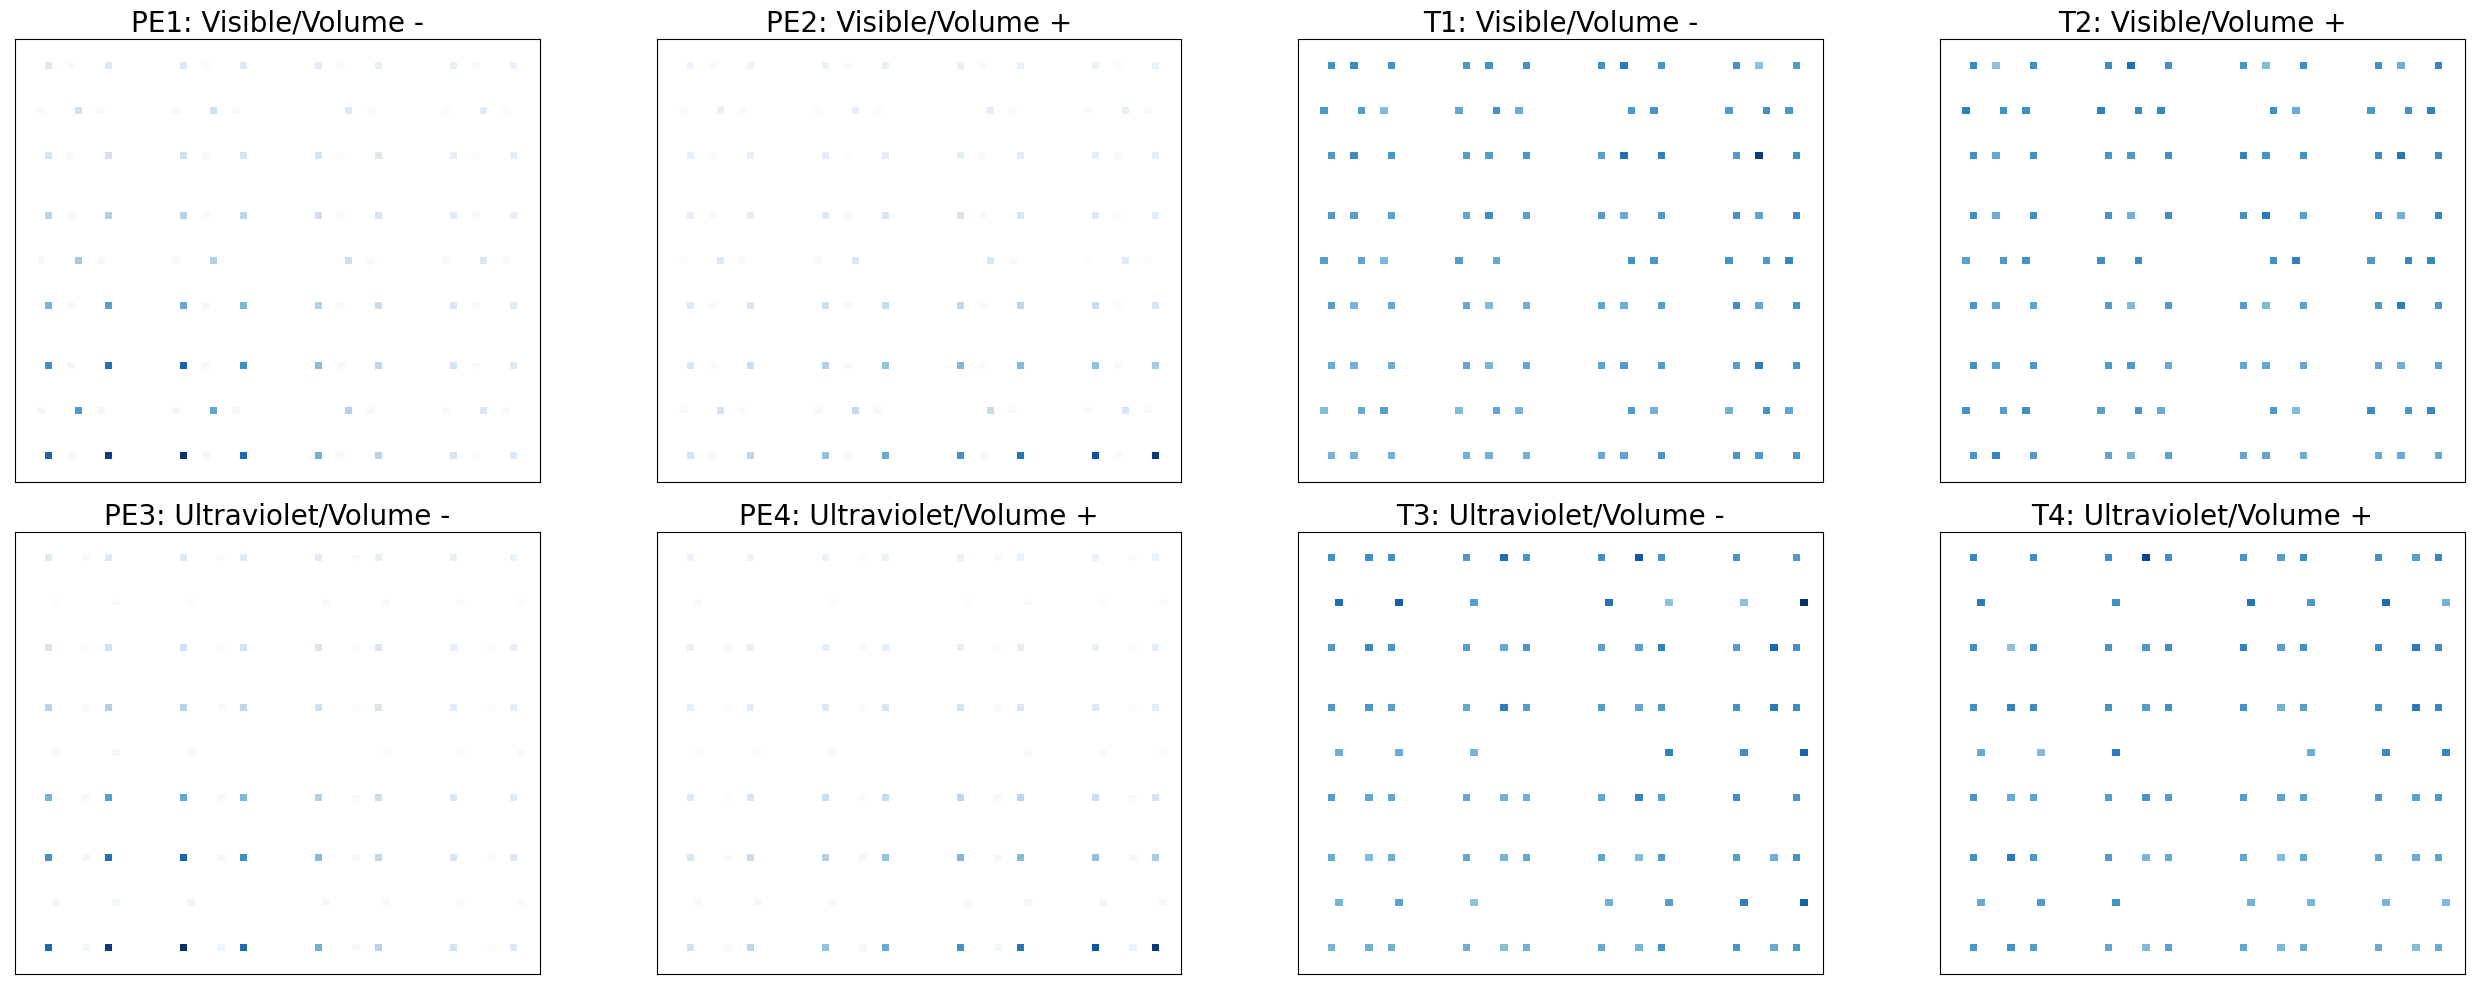

In [11]:
plot_image(image_realistic_visvuv, event_idx, labels_visvuv, groups_visvuv, grid_visvuv, figsize=(26, 10))

(<Figure size 2600x500 with 8 Axes>,
 array([<AxesSubplot:title={'center':'PE1: Visible/Volume -'}>,
        <AxesSubplot:title={'center':'PE2: Visible/Volume +'}>,
        <AxesSubplot:title={'center':'T1: Visible/Volume -'}>,
        <AxesSubplot:title={'center':'T2: Visible/Volume +'}>,
        <AxesSubplot:title={'center':'PE3: Ultraviolet/Volume -'}>,
        <AxesSubplot:title={'center':'PE4: Ultraviolet/Volume +'}>,
        <AxesSubplot:title={'center':'T3: Ultraviolet/Volume -'}>,
        <AxesSubplot:title={'center':'T4: Ultraviolet/Volume +'}>],
       dtype=object))

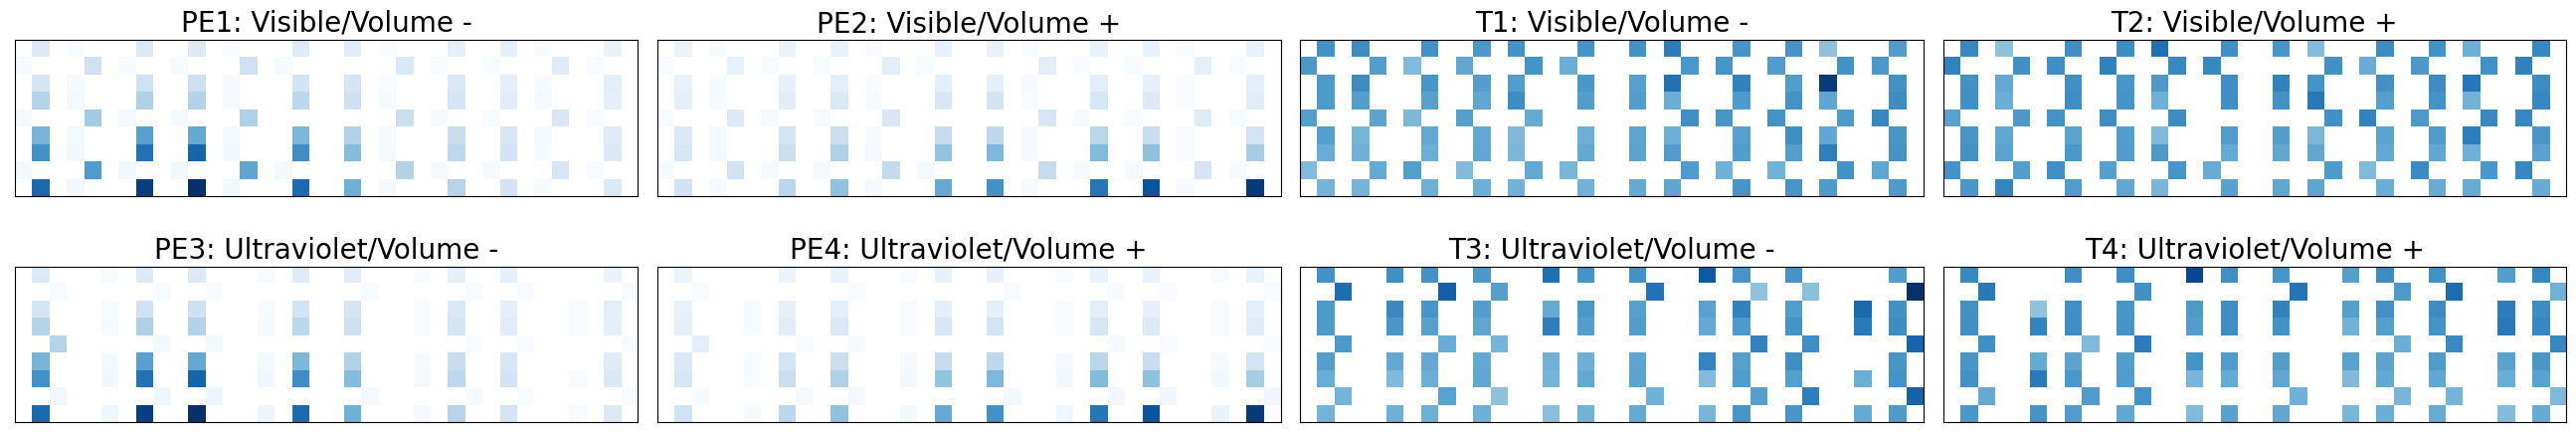

In [13]:
plot_image(image_compressed_visvuv, event_idx, labels_visvuv, groups_visvuv, grid_visvuv, figsize=(26, 5))

## Prueba sobre el Porcentaje de entradas nulas en las imágenes (cerca del 98%).

In [5]:
image_realistic_visvuv= np.load("/data/vidales/images/image_realistic_visvuv.npy")

In [9]:
# Check the shape of the image to understand how to visualize it
print(f"Image shape: {image_realistic_visvuv[0].shape}")

Image shape: (59, 70, 8)


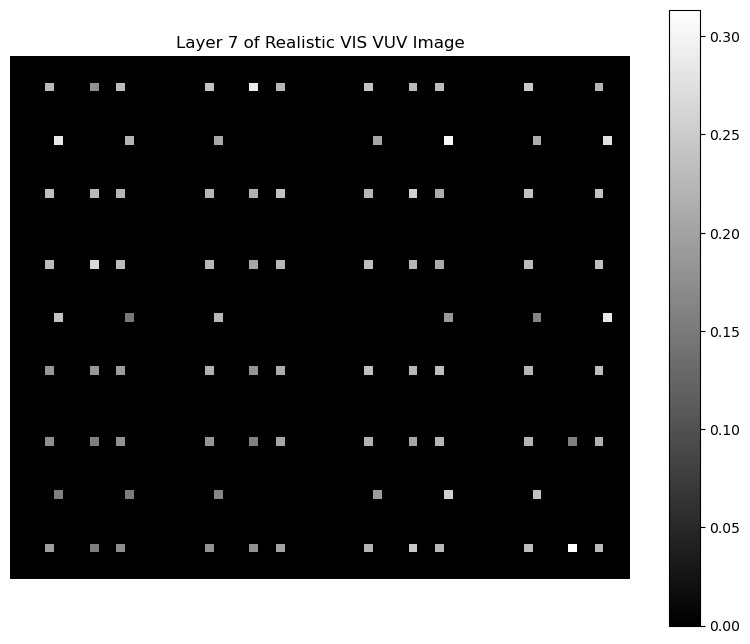

In [21]:
# Select one of the eight layers (e.g., the first layer)
layer_index = 6  # Change this index to select a different layer (0-7)
layer_to_plot = image_realistic_visvuv[0, :, :, layer_index]

# Plot the selected layer
plt.figure(figsize=(10, 8))
plt.imshow(layer_to_plot, cmap='gray')  # Use 'gray' for grayscale images
plt.colorbar()  # Optional: to show the color scale
plt.title(f'Layer {layer_index + 1} of Realistic VIS VUV Image')
plt.axis('off')  # Optional: to hide the axes
plt.show()

In [22]:
# Count the number of zeros
zero_count = np.sum(layer_to_plot == 0)

# Calculate the total number of elements
total_elements = layer_to_plot.size

# Calculate the percentage of zeros
percentage_zeros = (zero_count / total_elements) * 100

print("Number of zeros:", zero_count)
print("Total elements:", total_elements)
print("Percentage of zeros: {:.2f}%".format(percentage_zeros))

Number of zeros: 4043
Total elements: 4130
Percentage of zeros: 97.89%
